# Builds a custom CNN for Lunar Crater Classification (LROCNet).

### 1. Started with classic pattern: Conv2D -> BN -> ReLU -> Pooling 
 ##### Main target -the pipeline running 
 ##### Architect - 3 convoluation blocks, Flaten, 1 Dense layer

In [31]:
%pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tensorflow_addons]tensorflow_addons]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
import os
import matplotlib.pyplot as plt

2025-12-10 11:29:53.903586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/santanu/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/santanu/.pyenv/versions/3.10.6/lib/python3.10/runpy

AttributeError: _ARRAY_API not found

In [3]:
# Data directories
DATA_DIR = "/home/santanu/code/VMontejo/lunar-crater-age-classifier/raw_data/train"


In [4]:
IMG_HEIGHT = 227
IMG_WIDTH = 227
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
NUM_CLASSES = 3

### 2. Data Loading (Standardization Pipeline)

In [5]:
DATASET_MEAN = 85.3350  # extracted from Lornet EDA.ipynb
DATASET_STD  = 40.4752  # extracted from Lornet EDA.ipynb

def z_score_standardization(image):
    """
    Applies (Pixel - Mean) / Std to every pixel.
    Input image is 0-255.
    """
    image = tf.cast(image, tf.float32)
    return (image - DATASET_MEAN) / DATASET_STD

In [6]:
# 1. Create the Data Generator with Custom Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=z_score_standardization, # <--- Z-Score happens here
    validation_split=0.2
)

In [7]:
# 2. Setup Training Generator (RGB Mode)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True
)

Found 2888 images belonging to 3 classes.


In [8]:
#3. Setup Validation Generator (RGB Mode)
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=False
)

Found 720 images belonging to 3 classes.


In [9]:
print(f" Pipeline Configured: Input (227, 227, 3) | Normalization: Z-Score")

 Pipeline Configured: Input (227, 227, 3) | Normalization: Z-Score


### 3. Handling class Imbalance

In [10]:
# Extract the class labels from the generator
train_labels = train_generator.classes

# Calculate weights
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to dictionary format required by Keras
class_weights_dict = dict(enumerate(class_weights_vals))

print("\n⚖️ Computed Class Weights (Bias Correction):")
for class_id, weight in class_weights_dict.items():
    class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(class_id)]
    print(f"   {class_name}: {weight:.4f}")


⚖️ Computed Class Weights (Bias Correction):
   ejecta: 3.3542
   none: 0.4530
   oldcrater: 2.0224


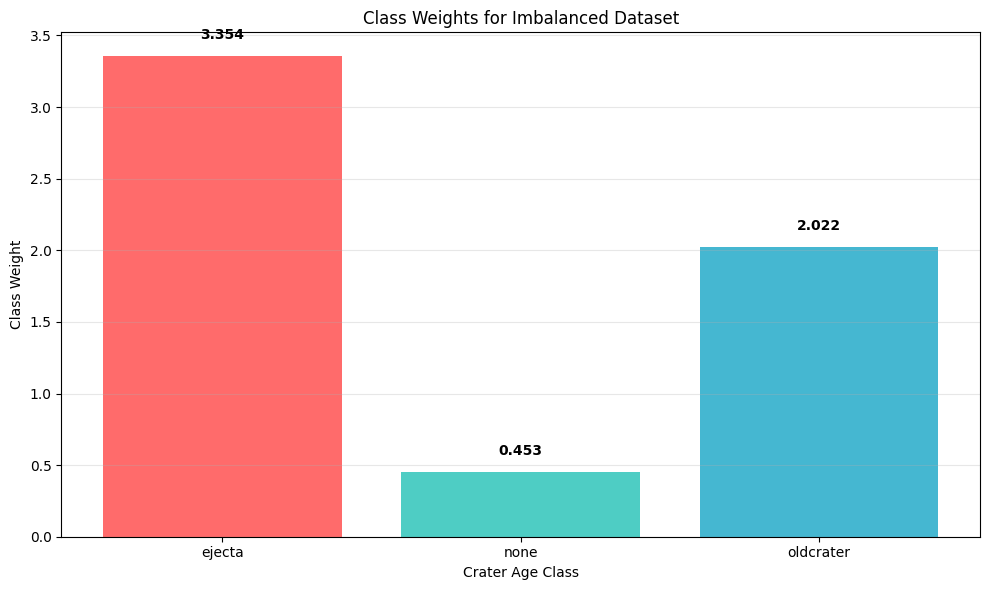

In [11]:
# Create bar plot for class weights
plt.figure(figsize=(10, 6))
classes = list(train_generator.class_indices.keys())
weights = list(class_weights_dict.values())

plt.bar(classes, weights, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.xlabel('Crater Age Class')
plt.ylabel('Class Weight')
plt.title('Class Weights for Imbalanced Dataset')
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for i, (cls, wt) in enumerate(zip(classes, weights)):
    plt.text(i, wt + 0.1, f'{wt:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 4. Custom Architect Model


In [24]:
def build_lroc_model(input_shape, num_classes):
    model = models.Sequential(name="LROC_Custom_CNN_RGB")

    #---input Block----
    model.add(layers.InputLayer(shape=input_shape))

    #---Block1: Edge&Lines---
    model.add(layers.Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block2: Simple Shape---
    model.add(layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block3: Complex texture---
    model.add(layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block 4: Deeper Features(Rays/Ejecta)---
    model.add(layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Classification Block---
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))

    #Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [12]:
# Build with RGB shape
model = build_lroc_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
model.summary()

2025-12-09 22:11:40.169368: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "LROC_Custom_CNN_RGB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 227, 227, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 227, 227, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 227, 227, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 113, 113, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 113, 113, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,899 (1.74 MB)

 Trainable params: 455,939 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

### 5. Compilation and callback

In [13]:
# 1. Compile
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# 2. Define Callbacks
callbacks = [
    # Stop training if validation loss doesn't improve for 5 epochs
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Save the best model automatically in the native Keras format
    ModelCheckpoint('best_lroc_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),

    # Slow down learning rate if the model gets stuck
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

print("✅ Model compiled. Callbacks configured to save as .keras")

✅ Model compiled. Callbacks configured to save as .keras


### 6. Training model fit

In [ ]:
print(f"Training with Class Weights: {class_weights_dict}")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict,  # <--- The Imbalance Fix
    callbacks=callbacks,
    verbose=1
)

print("✅ Training Complete.")

### 7. Performance visualization

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

### 8. Confusion Matix

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 1. Get Predictions
print("Generating Confusion Matrix...")
validation_generator.reset() # Reset to ensure order matches labels
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

In [ ]:
# 2. Generate Matrix
cm = confusion_matrix(true_classes, predicted_classes)

In [ ]:
# 3. Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix: Where is the model failing?')
plt.show()

In [ ]:
# 4. Print detailed Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

## 9. Update model

In [7]:
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    color_mode='rgb',
    subset='training',
    shuffle=True
)

Found 2888 images belonging to 3 classes.


In [8]:
#3. Setup Validation Generator (RGB Mode)
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    color_mode='rgb',
    subset='validation',
    shuffle=False
)


Found 720 images belonging to 3 classes.


In [28]:
def build_lroc_model(input_shape, num_classes):
    model = models.Sequential(name="LROC_Custom_CNN_RGB")

    #---input Block----
    model.add(layers.InputLayer(shape=input_shape))

    #---Block1: Edge&Lines---
    model.add(layers.Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block2: Simple Shape---
    model.add(layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block3: Complex texture---
    model.add(layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block 4: Deeper Features(Rays/Ejecta)---
    model.add(layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Classification Block---
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))

    #Output Layer
    model.add(layers.Dense(num_classes, activation='relu'))

    return model

In [30]:
# 1. Compile
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE,
                            global_clipnorm=1.0,
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- FIX 2: ROBUST CALLBACKS ---
callbacks = [
    # Stop training if validation loss doesn't improve for 5 epochs
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Save the best model automatically in the native Keras format
    ModelCheckpoint('best_lroc_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),

    # Slow down learning rate if the model gets stuck
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

print("✅ Model compiled. Callbacks configured to save as .keras")

✅ Model compiled. Callbacks configured to save as .keras


In [ ]:
print(f"Training with Class Weights: {class_weights_dict}")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict,  # <--- The Imbalance Fix
    callbacks=callbacks,
    verbose=1
)

print("✅ Training Complete.")

## 10. Update model -2

In [12]:
# --- FIX 1: SOFTEN THE CLASS WEIGHTS ---
# We take the square root to dampen the effect.
# This keeps the minority important, but stops the model from panicking.
for class_id in class_weights_dict:
    original_weight = class_weights_dict[class_id]
    softened_weight = np.sqrt(original_weight)
    class_weights_dict[class_id] = softened_weight
print("\n⚖️ Softened Class Weights (After Square Root):")
for class_id, weight in class_weights_dict.items():
    class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(class_id)]
    print(f"   {class_name}: {weight:.4f}")


⚖️ Softened Class Weights (After Square Root):
   ejecta: 1.8315
   none: 0.6731
   oldcrater: 1.4221


In [13]:
# --- FIX 2: ADD DATA AUGMENTATION ---
# Craters have "Rotational Invariance" (they look the same rotated).
train_datagen = ImageDataGenerator(
    preprocessing_function=z_score_standardization, # Keep your Z-score!
    validation_split=0.2,
    rotation_range=90,      # Rotate images randomly up to 90 deg
    horizontal_flip=True,   # Mirror image left/right
    vertical_flip=True,     # Mirror image up/down
    zoom_range=0.2,         # Zoom in/out slightly
    fill_mode='reflect'     # Handle edges
)

In [14]:
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    color_mode='rgb',
    subset='training',
    shuffle=True
)

Found 2888 images belonging to 3 classes.


In [15]:
# Validation data should NOT be augmented (only Z-score)
val_datagen = ImageDataGenerator(
    preprocessing_function=z_score_standardization,
    validation_split=0.2
)

In [16]:
#3. Setup Validation Generator (RGB Mode)
validation_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    color_mode='rgb',
    subset='validation',
    shuffle=False
)

Found 720 images belonging to 3 classes.


In [25]:
def build_lroc_model(input_shape, num_classes):
    model = models.Sequential(name="LROC_Custom_CNN_RGB")

    #---input Block----
    model.add(layers.InputLayer(shape=input_shape))

    #---Block1: Edge&Lines---
    model.add(layers.Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block2: Simple Shape---
    model.add(layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block3: Complex texture---
    model.add(layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block 4: Deeper Features(Rays/Ejecta)---
    model.add(layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Classification Block---
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))

    #Output Layer
    model.add(layers.Dense(num_classes, activation='relu'))

    return model

In [26]:
model = build_lroc_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
model.summary()

Model: "LROC_Custom_CNN_RGB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 227, 227, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 227, 227, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 227, 227, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 113, 113, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 113, 113, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,899 (1.74 MB)

 Trainable params: 455,939 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [27]:
# 1. Compile
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE,
                            global_clipnorm=1.0,
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- FIX 2: ROBUST CALLBACKS ---
callbacks = [
    # Stop training if validation loss doesn't improve for 5 epochs
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Save the best model automatically in the native Keras format
    ModelCheckpoint('best_lroc_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),

    # Slow down learning rate if the model gets stuck
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

print("✅ Model compiled. Callbacks configured to save as .keras")

✅ Model compiled. Callbacks configured to save as .keras


In [ ]:
print(f"Training with Class Weights: {class_weights_dict}")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict,  # <--- The Imbalance Fix
    callbacks=callbacks,
    verbose=1
)

print("✅ Training Complete.")

### 10.1 Update model -2-updated focal loss

In [22]:
# added focal loss

alpha = tf.constant([1.8315, 0.6731, 1.4221], dtype=tf.float32) # class weights for ejecta, none, oldcrater
gamma = 2.0

def focal_loss(y_true, y_pred):
    """
    Sparse categorical focal loss implementation
    y_true: shape (batch_size,) - class indices
    y_pred: shape (batch_size, num_classes) - predicted probabilities
    """
    # Convert labels to int32
    y_true = tf.cast(y_true, tf.int32)

    # Clip predictions to prevent log(0)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

    # Get the predicted probability for the true class
    batch_size = tf.shape(y_true)[0]
    indices = tf.stack([tf.range(batch_size), y_true], axis=1)
    p_t = tf.gather_nd(y_pred, indices)

    # Get alpha for each sample
    alpha_t = tf.gather(alpha, y_true)

    # Calculate focal loss
    focal_weight = alpha_t * tf.pow(1.0 - p_t, gamma)
    loss = -focal_weight * tf.math.log(p_t)

    return tf.reduce_mean(loss)


#### Model

In [23]:
def build_lroc_model(input_shape, num_classes):
    model = models.Sequential(name="LROC_Custom_CNN_RGB")

    #---input Block----
    model.add(layers.InputLayer(shape=input_shape))

    #---Block1: Edge&Lines---
    model.add(layers.Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block2: Simple Shape---
    model.add(layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block3: Complex texture---
    model.add(layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Block 4: Deeper Features(Rays/Ejecta)---
    model.add(layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))

    #---Classification Block---
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))

    #Output Layer
    model.add(layers.Dense(num_classes, activation='relu'))

    return model

In [24]:
model = build_lroc_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
model.summary()

Model: "LROC_Custom_CNN_RGB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 227, 227, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 227, 227, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 227, 227, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 113, 113, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 113, 113, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,899 (1.74 MB)

 Trainable params: 455,939 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [27]:
# 1. Compile
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE,
                            global_clipnorm=1.0,
)

model.compile(
    optimizer=optimizer,
    loss=focal_loss,
    metrics=['accuracy']
)

# --- FIX 2: ROBUST CALLBACKS ---
callbacks = [
    # Stop training if validation loss doesn't improve for 5 epochs
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Save the best model automatically in the native Keras format
    ModelCheckpoint('best_lroc_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),

    # Slow down learning rate if the model gets stuck
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

print("✅ Model compiled. Callbacks configured to save as .keras")

✅ Model compiled. Callbacks configured to save as .keras


In [ ]:
print(f"Training with Class Weights: {class_weights_dict}")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict,  # <--- The Imbalance Fix
    callbacks=callbacks,
    verbose=1
)

print("✅ Training Complete.")